# Calculate distances between character embeddings fanfic <-> canon

In [1]:
from gensim.models import KeyedVectors, FastText 

In [2]:
fanfic_mt_embs_fpath = '/usr0/home/jfiacco/Research/fanfic/embeddings/fanfic.harry_potter.1k-5k.lower.model.vec'
fanfic_mt_embs = KeyedVectors.load_word2vec_format(fanfic_mt_embs_fpath)

# fanfic_mt_embs_fpath = '/usr0/home/jfiacco/Research/fanfic/embeddings/fanfic.harry_potter.1k-5k.lower.model.bin'
# fanfic_mt_embs = FastText.load_fasttext_format(fanfic_embs_fpath)

In [3]:
canon_mt_embs_fpath = '/usr0/home/jfiacco/Research/fanfic/embeddings/canon.harry_potter.lower.model.vec'

canon_mt_embs = KeyedVectors.load_word2vec_format(canon_mt_embs_fpath)

## Align embeddings to background space

In [4]:
# Load transformation matrices
import numpy as np

fanfic2bg_path = '/usr0/home/qinlans/ACL_2019/transformation_matrices/fanfic_to_background.harry_potter.mikolov.nptxt'
fanfic2bg = np.loadtxt(fanfic2bg_path)
print(fanfic2bg.shape)

canon2bg_path = '/usr0/home/qinlans/ACL_2019/transformation_matrices/canon_to_background.harry_potter.mikolov.nptxt'
canon2bg = np.loadtxt(canon2bg_path)
print(canon2bg.shape)

(100, 100)
(100, 100)


In [5]:
minor_chars = [
    'percy',
    'fred',
    'lavender',
]

chars = [
    'harry',
    'hermione',
    'ron',
    'ginny',
    'draco',
    'sirius',
    'remus',
    'severus',
    'neville',
    'luna',
] + minor_chars

print(len(chars))
print(len(minor_chars))

13
3


In [7]:
char_vecs = {}

for c in chars:
# for c in minor_chars:
    char_vecs[c] = {}
    char_vecs[c]['fanfic'] = np.matmul(fanfic2bg, fanfic_mt_embs[c]) 
    char_vecs[c]['canon'] = np.matmul(canon2bg, canon_mt_embs[c]) 

In [8]:
from scipy.spatial.distance import cosine

for c in chars:
# for c in minor_chars:
    char_vecs[c]['dist_f-c'] = cosine(char_vecs[c]['fanfic'], char_vecs[c]['canon'])

# Calculate local context character name vectors

In [9]:
context_windows = [10, 25, 50] # before and after, so total window is this value * 2
fics_fpath = '/usr0/home/mamille2/erebor/fanfiction-project/data/ao3/harrypotter/dataset_1k-5k/filtered_paras'
canon_fpath = '/usr0/home/jfiacco/Research/fanfic/canon_data/harry_potter_tokenized/'

## Local context for fanfic

In [11]:
import os
from tqdm import tqdm_notebook as tqdm

char_contexts_fanfic = {}
for c in chars:
    char_contexts_fanfic[c] = {w: [] for w in context_windows}

for fname in tqdm(sorted(os.listdir(fics_fpath))):
    
    with open(os.path.join(fics_fpath, fname)) as f:
        paras = [p.split() for p in f.read().splitlines()]
        for c in chars:
#         for c in minor_chars:
            
            fic_contexts = {w: [] for w in context_windows}
            
            for para in paras:
                for idx in [i for i,token in enumerate(para) if token==c]:
                    for context_window in context_windows:
                        
                        fic_contexts[context_window] += para[max(0, idx-context_window) : idx] # before
                        fic_contexts[context_window] += para[idx+1 : min(idx+1+context_window, len(para))] # after
    
            for context_window in context_windows:
                char_contexts_fanfic[c][context_window].append(fic_contexts[context_window])

In [12]:
# Build, store aligned fanfic vectors

fanfic_aligned = {}

for c in tqdm(chars):
# for c in tqdm(minor_chars):
    for context_window in context_windows:
        for context_wds in char_contexts_fanfic[c][context_window]:
            context_wds = set(context_wds)
            for w in context_wds:
                if not w in fanfic_aligned and w in fanfic_mt_embs:
                    fanfic_aligned[w] = np.matmul(fanfic2bg, fanfic_mt_embs[w])

In [14]:
char_contexts_fanfic['harry'][10][:10]

[[],
 [],
 [],
 ['a',
  'loud',
  'sigh',
  'followed',
  'by',
  'her',
  'usual',
  'mantra',
  ',',
  '“',
  ',',
  'will',
  'you',
  'just',
  'tell',
  'him',
  'already',
  '!',
  'it',
  'will',
  'just',
  'nodded',
  ',',
  'but',
  'inside',
  'he',
  'was',
  'a',
  'bundle',
  'of',
  '?',
  'flourish',
  'and',
  'blotts',
  'is',
  'selling',
  'a',
  'new',
  'book',
  'about',
  '.',
  'it',
  'says',
  '…',
  ')',
  '.',
  '.',
  'and',
  'he',
  'had',
  'never',
  'felt',
  'anything',
  'but',
  'friendship',
  'from',
  '.',
  'so',
  ',',
  'there',
  'it',
  'was',
  '…',
  'friendship',
  '.',
  'he',
  'maybe',
  'not',
  'satisfied',
  ',',
  'but',
  'certainly',
  'thankful',
  'to',
  'remain',
  'in',
  '’s',
  'life',
  '.',
  '“',
  'you',
  ',',
  '”',
  'hermione',
  'softly',
  'said',
  'to',
  '.',
  'each',
  'occupant',
  '.',
  'ron',
  'looked',
  'to',
  'hermione',
  'and',
  'then',
  'to',
  '.',
  'hermione',
  'looked',
  'to',
  'harry',

In [19]:
# Get TF-IDF weighting for terms

from sklearn.feature_extraction.text import TfidfVectorizer

idf_weights_fanfic = {}

for c in chars:
    idf_weights_fanfic[c] = {}
    
    for cw in tqdm(context_windows):
        vectorizer = TfidfVectorizer(stop_words='english')
        vectorizer.fit([' '.join(toks) for toks in char_contexts_fanfic[c][cw]])
        idf_weights_fanfic[c][cw] = (vectorizer.vocabulary_, vectorizer.idf_)

In [20]:
idf_weights['harry'][10][1].shape

(60042,)

In [46]:
from IPython.core.debugger import set_trace

# Get contextualized fanfic vectors

# char_vecs_per_fic = {c: {cw: [] for cw in context_windows} for c in chars}
char_vecs_per_fic = {}
for c in chars:
    char_vecs_per_fic[c] = {w: [] for w in context_windows}

for c in tqdm(chars):
# for c in tqdm(minor_chars):
    for cw in context_windows:
        for context_wds in char_contexts_fanfic[c][cw]: # for every fic, sorted
            if len(context_wds) == 0: continue
                
            wd_indices, wd_weights = idf_weights[c][cw]
            context_embs = [fanfic_aligned[w] * wd_weights[wd_indices[w]] for w in context_wds if \
                            w in fanfic_mt_embs and w in wd_indices]
            context_vec = np.mean(context_embs, axis=0)
            
#             char_vec = np.hstack([char_vecs[c]['fanfic'], context_vec])
#             if char_vec.shape != (200,): continue # only context words found are not in vocabulary
#             char_vec = np.mean([char_vecs[c]['fanfic'], context_vec], axis=0)

            char_vec = context_vec
            if char_vec.shape != (100,): continue # only context words found are not in vocabulary
            char_vecs_per_fic[c][cw].append(char_vec)

        char_vecs[c][f'fanfic_lc{cw}_context'] = np.mean(char_vecs_per_fic[c][cw], axis=0)
#         print(char_vecs[c][f'fanfic_lc{cw}_context'].shape)

/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/mamille2/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
len(char_contexts_fanfic['harry'][10])

67957

In [47]:
len(char_vecs_per_fic['harry'][10])

39202

In [40]:
idf_weights['harry'][10][0]

{'loud': 30728,
 'sigh': 47249,
 'followed': 20081,
 'usual': 56484,
 'mantra': 31600,
 'just': 28384,
 'tell': 52342,
 'nodded': 35257,
 'inside': 27003,
 'bundle': 7204,
 'flourish': 19915,
 'blotts': 5911,
 'selling': 46173,
 'new': 34925,
 'book': 6224,
 'says': 45387,
 'felt': 19017,
 'friendship': 20654,
 'maybe': 32017,
 'satisfied': 45285,
 'certainly': 8492,
 'thankful': 52645,
 'remain': 43038,
 'life': 30050,
 'hermione': 24356,
 'softly': 48645,
 'said': 44978,
 'occupant': 35926,
 'ron': 44371,
 'looked': 30611,
 'harry': 23725,
 'process': 40471,
 'repeated': 43230,
 'silence': 47306,
 'reigned': 42844,
 'flat': 19657,
 'finally': 19345,
 'garnered': 21278,
 'strength': 50536,
 'ask': 3410,
 'wh': 58281,
 'loves': 30782,
 'like': 30132,
 'love': 30757,
 'closed': 9645,
 'door': 15172,
 'did': 14018,
 'want': 57778,
 'look': 30607,
 'horror': 25140,
 'face': 18443,
 'heard': 24002,
 'clear': 9494,
 'throat': 52956,
 'say': 45379,
 'short': 46963,
 'affirmative': 1448,
 'no

## Local context for canon

In [26]:
import os
from tqdm import tqdm_notebook as tqdm

char_contexts_canon = {}
for c in chars:
    char_contexts_canon[c] = {w: [] for w in context_windows}

for fname in tqdm(sorted(os.listdir(canon_fpath))):
    
    with open(os.path.join(canon_fpath, fname)) as f:
        paras = [p.lower().split() for p in f.read().splitlines()]
        for c in chars:
#         for c in minor_chars:
            
            fic_contexts = {w: [] for w in context_windows}
            
            for para in paras:
                for idx in [i for i,token in enumerate(para) if token==c]:
                    for context_window in context_windows:
                        
                        fic_contexts[context_window] += para[max(0, idx-context_window) : idx] # before
                        fic_contexts[context_window] += para[idx+1 : min(idx+1+context_window, len(para))] # after
    
            for context_window in context_windows:
                char_contexts_canon[c][context_window].append(fic_contexts[context_window])

In [27]:
# Build, store aligned canon vectors

canon_aligned = {}

for c in tqdm(chars):
# for c in tqdm(minor_chars):
    for context_window in context_windows:
        for context_wds in char_contexts_canon[c][context_window]:
            context_wds = set(context_wds)
            for w in context_wds:
                if not w in canon_aligned and w in canon_mt_embs:
                    canon_aligned[w] = np.matmul(canon2bg, canon_mt_embs[w])

In [28]:
# Get TF-IDF weighting for terms

from sklearn.feature_extraction.text import TfidfVectorizer

idf_weights_canon = {}

for c in tqdm(chars):
    idf_weights_canon[c] = {}
    
    for cw in context_windows:
        vectorizer = TfidfVectorizer(stop_words='english')
        vectorizer.fit([' '.join(toks) for toks in char_contexts_canon[c][cw]])
        idf_weights_canon[c][cw] = (vectorizer.vocabulary_, vectorizer.idf_)

In [48]:
from IPython.core.debugger import set_trace

# Get contextualized canon vectors

# char_vecs_per_canon = {c: {cw: [] for cw in context_windows} for c in chars}
char_vecs_per_canon = {}
for c in chars:
    char_vecs_per_canon[c] = {w: [] for w in context_windows}

for c in tqdm(chars):
# for c in tqdm(minor_chars):
    for cw in context_windows:
        for context_wds in char_contexts_canon[c][cw]: # for every canon, sorted
            if len(context_wds) == 0: continue
                
            wd_indices, wd_weights = idf_weights[c][cw]
            context_embs = [canon_aligned[w] * wd_weights[wd_indices[w]] for w in context_wds if \
                            w in canon_mt_embs and w in wd_indices]
            context_vec = np.mean(context_embs, axis=0)
            
#             char_vec = np.hstack([char_vecs[c]['canon'], context_vec])
#             if char_vec.shape != (200,): continue # only context words found are not in vocabulary
#             char_vec = np.mean([char_vecs[c]['canon'], context_vec], axis=0)

            char_vec = context_vec
            if char_vec.shape != (100,): continue # only context words found are not in vocabulary
            char_vecs_per_canon[c][cw].append(char_vec)

        char_vecs[c][f'canon_lc{cw}_context'] = np.mean(char_vecs_per_canon[c][cw], axis=0)
#         print(char_vecs[c][f'canon_lc{cw}_context'].shape)

## Distances canon-fanfic

In [31]:
for c in chars:
# for c in minor_chars:
    for cw in context_windows:
        char_vecs[c][f'dist_lc{cw}_context_f-c'] = cosine(char_vecs[c][f'fanfic_lc{cw}_context'], char_vecs[c][f'canon_lc{cw}_context'])

In [113]:
char_vecs['harry'].keys()

dict_keys(['fanfic', 'canon', 'dist_f-c', 'fanfic_lc10_context', 'fanfic_lc25_context', 'fanfic_lc50_context', 'canon_lc10_context', 'canon_lc25_context', 'canon_lc50_context', 'dist_lc10_context_f-c', 'dist_lc25_context_f-c', 'dist_lc50_context_f-c'])

In [34]:
# Save char_vecs pickle
import pickle

with open('/usr0/home/mamille2/erebor/fanfiction-project/embeddings/char_vecs_lc_tfidf.pkl', 'wb') as f:
    pickle.dump(char_vecs, f)

In [32]:
# With tf-idf weighting

from scipy.stats import pearsonr

selected_chars = ['neville', 'luna', 'fred', 'percy', 'lavender']
other_chars = ['harry', 'ron', 'hermione']

# Calculate correlation
for cw in context_windows:
    print(cw)
    print(pearsonr([char_vecs[c]['dist_f-c'] for c in chars], [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in chars]))
    print(pearsonr([char_vecs[c]['dist_f-c'] for c in selected_chars], [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in selected_chars]))
    print(pearsonr([char_vecs[c]['dist_f-c'] for c in other_chars], [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in other_chars]))

10
(0.6499071084257844, 0.01619357645750843)
(0.9589163862126312, 0.009934413154022341)
(0.2595829856371206, 0.8328297840650982)
25
(0.18434240043912642, 0.5465826410770306)
(0.8318835440231716, 0.08062736996050436)
(0.1149497547938569, 0.9266585889808316)
50
(0.02921328353979393, 0.9245248292141783)
(0.6909760118421403, 0.19637608092971337)
(0.024946674753261972, 0.9841168058578751)


In [131]:
# Old figures

from scipy.stats import pearsonr

selected_chars = ['neville', 'luna', 'fred', 'percy', 'lavender']
other_chars = ['harry', 'ron', 'hermione']

# Calculate correlation
for cw in context_windows:
    print(cw)
    print(pearsonr([char_vecs[c]['dist_f-c'] for c in chars], [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in chars]))
    print(pearsonr([char_vecs[c]['dist_f-c'] for c in selected_chars], [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in selected_chars]))
    print(pearsonr([char_vecs[c]['dist_f-c'] for c in other_chars], [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in other_chars]))

10
(-0.17964043613289873, 0.5570353982290865)
(0.8705899600538916, 0.05478613631612198)
(-0.4247261021185322, 0.720740802186532)
25
(-0.29116777683494244, 0.33445706894028504)
(0.805791617972976, 0.09969223321360329)
(-0.4428584868241408, 0.7079288159087537)
50
(-0.2935303324583422, 0.3303686406924144)
(0.7531847853736737, 0.14161883144090584)
(-0.44284774362148693, 0.7079364440368447)


In [33]:
import pandas as pd

dists = pd.DataFrame([[char, dist, dist_context] for char,dist, dist_context in zip(chars,
                                                                          [char_vecs[c]['dist_f-c'] for c in chars],
                                                                          [char_vecs[c][f'dist_lc{cw}_context_f-c'] for c in chars])],
             columns=['name', 'dist_mt', 'dist_mt_context']
            )

dists.sort_values('dist_mt_context', inplace=True)
dists

,name,dist_mt,dist_mt_context
7,severus,0.123591,0.005576
5,sirius,0.138791,0.006389
4,draco,0.161000,0.007704
6,remus,0.246387,0.008454
3,ginny,0.081986,0.008551
1,hermione,0.056093,0.009131
10,percy,0.114344,0.009251
2,ron,0.069860,0.010887
11,fred,0.095534,0.010959
0,harry,0.051204,0.011474


In [49]:
dists.sort_values('dist_mt')

,name,dist_mt,dist_mt_context
0,harry,0.051204,0.011474
1,hermione,0.056093,0.009131
2,ron,0.069860,0.010887
3,ginny,0.081986,0.008551
11,fred,0.095534,0.010959
10,percy,0.114344,0.009251
8,neville,0.121217,0.012673
9,luna,0.121844,0.011965
7,severus,0.123591,0.005576
5,sirius,0.138791,0.006389


In [95]:
[char_vecs[c]['dist_f-c'] for c in minor_chars]

[0.11434434167034857, 0.09553433570146574, 0.24437178552179195]

In [96]:
[char_vecs[c]['dist_lc10_context_f-c'] for c in minor_chars]

[0.011835851252422702, 0.011611511384089557, 0.013267347650336103]

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


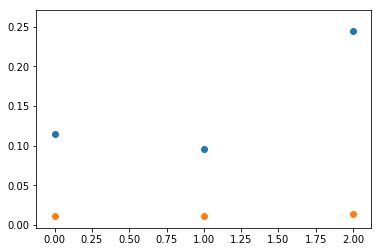

In [97]:
%matplotlib inline

plt.scatter(np.arange(len(minor_chars)), [char_vecs[c]['dist_f-c'] for c in minor_chars])
plt.scatter(np.arange(len(minor_chars)), [char_vecs[c]['dist_lc10_context_f-c'] for c in minor_chars])
plt.show()

# Plot character vectors

In [101]:
selected5_chars = ['harry', 'hermione', 'ron', 'draco', 'ginny']

## Reduce dimensions

In [109]:
all_char_vecs = []
char_labels = []

# Fanfic
for c in selected5_chars:
    all_char_vecs.extend(char_vecs_per_fic[c][10])
    char_labels.extend([f'{c}_fanfic'] * len(char_vecs_per_fic[c][10]))
    
# Canon
for c in selected5_chars:
    all_char_vecs.extend(char_vecs_per_canon[c][10])
    char_labels.extend([f'{c}_canon'] * len(char_vecs_per_canon[c][10]))
    
print(len(all_char_vecs))
print(len(char_labels))

120093
120093


In [110]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
reduced = pca.fit_transform(all_char_vecs)

In [111]:
%%timeit
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_reduced = tsne.fit_transform(reduced)

KeyboardInterrupt: 

In [51]:
tsne_reduced[0]

array([ 8.629038, 11.026836], dtype=float32)

In [71]:
# Save TSNE
import numpy as np

# np.save('/usr0/home/mamille2/erebor/fanfiction-project/output/tsne_chars_lc25.npy', tsne_reduced)
np.save('/usr0/home/mamille2/erebor/fanfiction-project/output/tsne_chars_lc10_context.npy', tsne_reduced)
np.save('/usr0/home/mamille2/erebor/fanfiction-project/output/tsne_chars_lc10_context_labels.npy', char_labels)

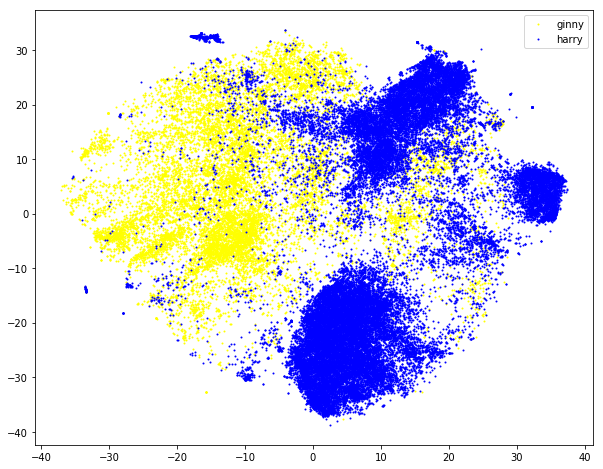

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.debugger import set_trace

chars2i = {c: i for i,c in enumerate(chars)}
cdict = {'draco': 'red', 'hermione': 'green', 'harry': 'blue', 'ginny': 'yellow', 'ron': 'purple'}
# selected_chars = ['harry', 'draco', 'ginny']
# selected_chars = ['harry', 'hermione', 'ron']
# selected_chars = ['hermione', 'ron', 'draco']
# selected_chars = ['hermione', 'ron']
# selected_chars = ['hermione', 'draco']
# selected_chars = ['harry', 'draco']
selected_chars = ['ginny', 'harry']


fig, ax = plt.subplots(figsize=(10,8))
# for c in np.unique(char_labels):
for c in selected_chars:
    ix = np.where(np.array(char_labels) == c)
#     plt.scatter(tsne_reduced[:,0][ix], tsne_reduced[:,1][ix], c=[chars2i[c] for c in char_labels], s=1, label=char_labels)
#     plt.scatter(tsne_reduced[:,0][ix], tsne_reduced[:,1][ix], c=chars2i[c], s=1, label=c)
#     ax.scatter(tsne_reduced[:,0][ix], tsne_reduced[:,1][ix], c=chars2i[c], s=1, label=c)
    ax.scatter(tsne_reduced[:,0][ix], tsne_reduced[:,1][ix], c=cdict[c], s=1, label=c)
    
ax.legend()
plt.show()